In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.stats as ss

from copy import deepcopy
import tqdm

# additionally requires libcpab (https://github.com/SkafteNicki/libcpab)
import nwarp

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### Load data

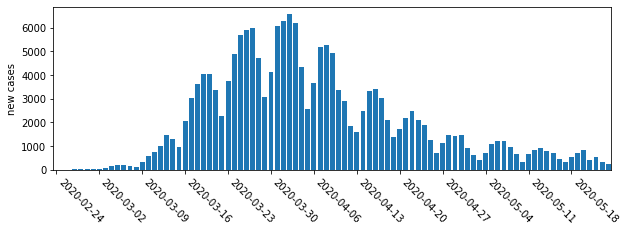

In [4]:
# Please download the official German Covid-19 data from Robert Koch Institut (https://www.rki.de/EN/) from
#    https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0
# manually via the button 'Herunterladen' -> 'Tabelle' and save it in the current working
# directory as 'RKI_COVID19.csv'. Alternatively, you can set the variable 'download' below to True to
# fetch the data automatically.
# The dataset contains official numbers of reported cases in Germany; the number at day t
# reflects reported cases at day t-1.

download = False
if download:
    import urllib.request
    dl_counter = tqdm.tqdm(desc="downloading")
    update_hook = lambda chk_nr, chk_sz, sz: dl_counter.update(chk_nr*chk_sz)
    urllib.request.urlretrieve('https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv',
                               'RKI_COVID19.csv', reporthook=update_hook)
    dl_counter.close()

rawdata = pd.read_csv("RKI_COVID19.csv", index_col=0, parse_dates=["Meldedatum"])
time_period = pd.date_range(start="2020-02-24", end="2020-05-24")
rawdata = rawdata[["Meldedatum", "AnzahlFall"]].groupby("Meldedatum").sum().squeeze()[time_period]

plt.figure(figsize=(10,3))
plt.bar(range(len(rawdata)), rawdata, lw=1, alpha=1)
plt.xlim(-0.5,len(rawdata)-0.5)
plt.ylabel("new cases")
plt.xticks(range(0, len(rawdata), 7), labels=[t.date() for t in time_period[::7]], rotation=-45, ha="left")
plt.show()

In [5]:
# use the raw data without any preprocessing
data = rawdata.values

# log-likelihood (LL) under a saturated Poisson model
# with one parameter per observation (\lambda_i = y_i)
LL_sat = np.sum(ss.poisson.logpmf(data, data))

# define targets y_t=data[t]
targets = torch.from_numpy(data.astype(np.float32)).reshape(1,-1,1)
N, T, Dout = targets.shape

# define covariates z_t=[onehot(day of week, excluding Monday), 1, t]
covariates = torch.cat([torch.nn.functional.one_hot(torch.from_numpy(time_period.dayofweek.values))[:,1:].float().unsqueeze(0),
                        torch.ones(1, T, 1),
                        torch.linspace(0, T-1, T).reshape(1,-1,1)],
                        dim=2).expand(N, -1, -1)

# Segmented Models

### Define model

In [6]:
# number of segments
K = 4

# Poisson regression: GLM with logarithmic link function (exponential inverse link function)
glm = nwarp.GeneralizedLinearModel(Dout, invlink_func=nwarp.Exp())

# TSP-based parameter warping with constant mode vector
Dparamg = 6 # number of global parameters (same in every segment)
Dparaml = 2 # number of local parameters (different in every segment)
paramwarpTSPB = nwarp.ParameterWarp(K, Dparamg, Dparaml,
                                    nwarp.TSPStepWarp(nwarp.Constant((K-1,)),
                                                      width=0.5, power=16.,
                                                      min_step=0.0001, max_step=0.9999))

paramwarpCPAB = nwarp.ParameterWarp(K, Dparamg, Dparaml,
                       nwarp.CPABWarp(K+1, nwarp.Constant((K,))))

paramwarpVanilla = nwarp.ParameterWarp(K, Dparamg, Dparaml,
                       nwarp.VanillaWarp(nwarp.Constant((T-1,)), nonneg_trans='square'))

paramwarp = paramwarpTSPB

print(paramwarp)
print(glm)

ParameterWarp(
  (warp): TSPStepWarp(
    (loc_net): Constant()
  )
  (resample): Resample()
)
GeneralizedLinearModel(
  (invlink_func): Exp()
)


### Training

In [7]:
n_restarts    = 10 # number of randomized restarts
n_epochs      = 10000
n_epochs_hard = 2048
show_plots    = True

loss_fn       = nn.PoissonNLLLoss(log_input=False, full=True, reduction='sum') # with invlink_func = nwarp.Exp()

restart  1/10: 100%|██████████| 10000/10000 [00:32<00:00, 304.07it/s, loss=2.25e+3]


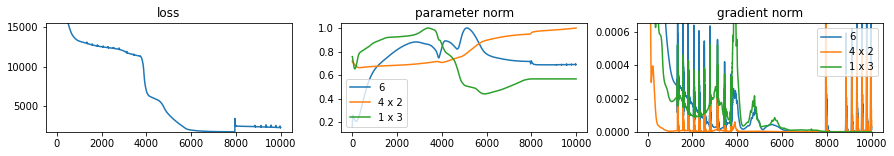

restart  2/10: 100%|██████████| 10000/10000 [00:32<00:00, 309.00it/s, loss=2.26e+3]


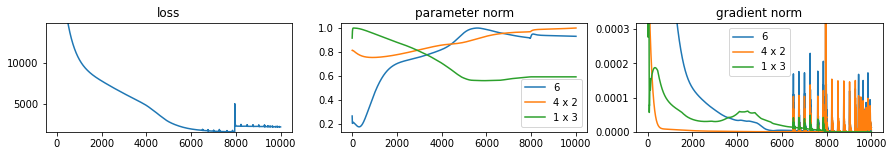

restart  3/10: 100%|██████████| 10000/10000 [00:32<00:00, 312.30it/s, loss=1.46e+3]


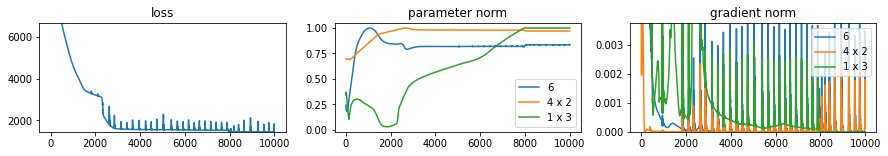

restart  4/10: 100%|██████████| 10000/10000 [00:33<00:00, 301.61it/s, loss=1.32e+3]


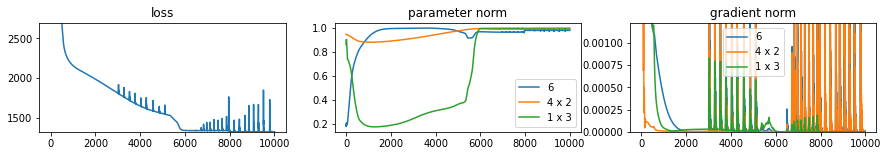

restart  5/10: 100%|██████████| 10000/10000 [00:35<00:00, 281.79it/s, loss=1.33e+4]


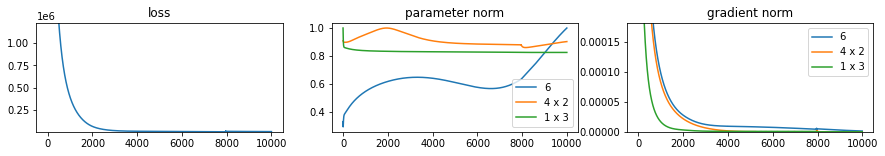

restart  6/10: 100%|██████████| 10000/10000 [00:33<00:00, 298.34it/s, loss=1.83e+3]


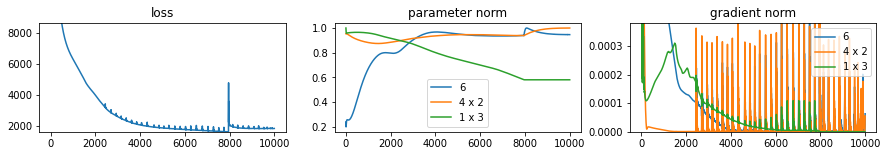

restart  7/10: 100%|██████████| 10000/10000 [00:32<00:00, 312.16it/s, loss=1.36e+3]


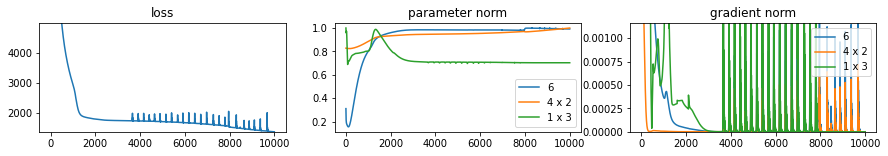

restart  8/10: 100%|██████████| 10000/10000 [00:31<00:00, 315.16it/s, loss=1.33e+3]


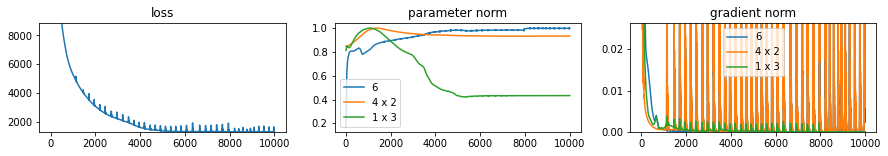

restart  9/10: 100%|██████████| 10000/10000 [00:32<00:00, 312.48it/s, loss=1.87e+4]


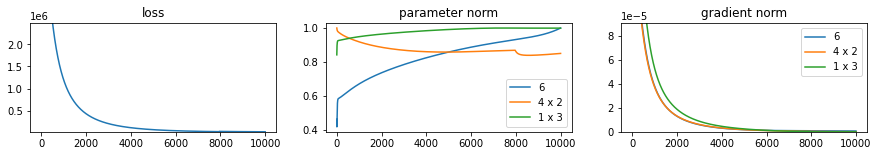

restart 10/10: 100%|██████████| 10000/10000 [00:30<00:00, 322.64it/s, loss=1.87e+3]


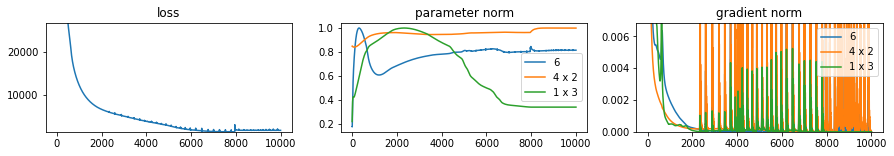

best loss = 1322.0264


In [8]:
best_loss = np.inf
for r in range(n_restarts):
    # reset everything
    optimizer = torch.optim.Adam(paramwarp.parameters(), lr=1e-2)
    param_norm = []
    grad_norm = []
    train_losses = []
    resample_kernel = "linear"
    epoch_counter = tqdm.tqdm(range(n_epochs), desc=f"restart {(r+1):2d}/{n_restarts:2d}")

    # initialize GLM parameters in reasonable range
    nn.init.uniform_(paramwarp.thetag, -0.1, 0.2) # day of week
    nn.init.uniform_(paramwarp.thetal[:,0], 3, 10) # bias
    nn.init.uniform_(paramwarp.thetal[:,1], -0.1, 0.2) # time
    
    # initialize segmentation
    try:
        # for TSP-based and CPA-based warping
        nn.init.uniform_(paramwarp.warp.loc_net.const, -1., 1.)
    except AttributeError:
        _ = paramwarp.apply(nwarp.reset_parameters)   

    # perform training
    paramwarp.train()
    for epoch in epoch_counter:
        optimizer.zero_grad()

        if epoch == n_epochs - n_epochs_hard:
            resample_kernel = "integer"

        param_hat = paramwarp(targets, resample_kernel=resample_kernel)[0]
        y_hat = glm(covariates, param_hat)
        loss = loss_fn(y_hat, targets)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        param_norm.append([sl.norm(p.detach()) for p in paramwarp.parameters()])
        grad_norm.append([sl.norm(p.grad.detach()) for p in paramwarp.parameters()])
        epoch_counter.set_postfix({"loss":loss.item()})

    if train_losses[-1] < best_loss:
        best_paramwarp_state = deepcopy(paramwarp.state_dict())
        best_loss = train_losses[-1]

    if show_plots:
        plt.figure(figsize=(15,2))
        plt.subplot(131)
        plt.title("loss")
        plt.ylim(np.min(train_losses), np.percentile(train_losses, 95))
        plt.plot(train_losses)

        plt.subplot(132)
        plt.title("parameter norm")
        normalized_param_norm = np.array(param_norm)/np.array(param_norm).max(axis=0)
        if not np.isnan(normalized_param_norm).any():
            lines = plt.plot(normalized_param_norm)
            plt.legend(lines, [" x ".join([str(d) for d in p.size()]) for p in paramwarp.parameters() if len(p)>0])

        plt.subplot(133)
        plt.title("gradient norm")
        normalized_grad_norm = (np.array(grad_norm)/np.array(grad_norm).max(axis=0))
        if not np.isnan(normalized_grad_norm).any():
            lines = plt.plot(normalized_grad_norm)
            plt.legend(lines, [" x ".join([str(d) for d in p.size()]) for p in paramwarp.parameters() if len(p)>0])
            plt.ylim(np.min(normalized_grad_norm), np.percentile(normalized_grad_norm, 95))

        plt.show()

paramwarp.eval()
paramwarp.load_state_dict(best_paramwarp_state)
print(f"best loss = {best_loss:.4f}")

### Evaluation

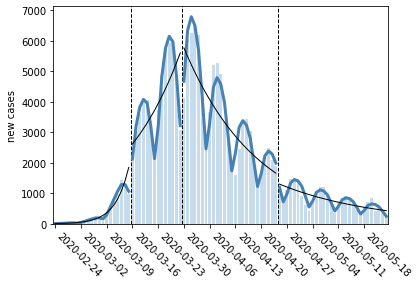

break points at:
    2020-03-16
    2020-03-30
    2020-04-25

incidence rate ratios: (exponentiated Poisson coefficients)
  time, daily growth rate, per segment
    (S1) = 1.3118
    (S2) = 1.0603
    (S3) = 0.9514
    (S4) = 0.9626
  day of week
    (Mo) := 1.0000 (baseline)
    (Tu)  = 1.4266
    (We)  = 1.6050
    (Th)  = 1.6139
    (Fr)  = 1.4770
    (Sa)  = 1.1243
    (Su)  = 0.7088
    mean  = 1.2337 (geometric)


In [9]:
param_hat, almat_hat, gamma_hat = paramwarp(targets, resample_kernel=resample_kernel)
y_hat = glm(covariates, param_hat)

bps = almat_hat[0].sum(dim=0).cumsum(dim=0)[:-1].detach()
segments = torch.cat((torch.Tensor([0]), bps, torch.Tensor([T]))).int()
for bp in bps:
    plt.axvline(bp-0.5, color="black", lw=1, ls="--")
plt.bar(range(T), data, lw=1, alpha=0.25)
for i in range(len(segments)-1):
    plt.plot(range(segments[i], segments[i+1]), y_hat[0,range(segments[i], segments[i+1]),0].detach(),
             color="steelblue", lw=3)
plt.xlim(-0.5,T-0.5)
plt.ylabel("new cases")
plt.xticks(range(0, T, 7), labels=[t.date() for t in time_period[::7]], rotation=-45, ha="left")

# average day of week effect (geometric mean, including effect of log(1)=0 for Mo)
no_dow_covariates = deepcopy(covariates[:,:,6:].detach())
no_dow_param_hat = deepcopy(param_hat[:,:,6:].detach())
no_dow_param_hat[0,:,0] += torch.cat((paramwarp.thetag.detach(), torch.Tensor([0]))).mean()
no_dow_y_hat = glm(no_dow_covariates, no_dow_param_hat).detach()
for i in range(len(segments)-1):
    plt.plot(range(segments[i], segments[i+1]), no_dow_y_hat[0,range(segments[i], segments[i+1]),0],
             color="black", lw=1)

plt.show()

print("break points at:")
for i, bp in enumerate(bps.int()):
    print(f"    {time_period[bp.item()].date()}")
print()
print("incidence rate ratios: (exponentiated Poisson coefficients)")
print("  time, daily growth rate, per segment")
for s, beta in enumerate(torch.exp(paramwarp.thetal[:,1].detach())):
    print(f"    (S{s+1}) = {beta:.4f}")
print("  day of week")
print(f"    (Mo) := 1.0000 (baseline)")
days = ["Tu", "We", "Th", "Fr", "Sa", "Su"]
for d, irr in enumerate(torch.exp(paramwarp.thetag).detach()):
    print(f"    ({days[d]})  = {irr:.4f}")
print(f"    mean  = {torch.exp(torch.cat((paramwarp.thetag.detach(), torch.Tensor([0]))).mean()):.4f} (geometric)")

### Model diagnostics

LL sat   = -393.2237
LL GLM   = -1322.1016
deviance = 1857.7559 (residual df=77)
  (1/df) = 24.1267


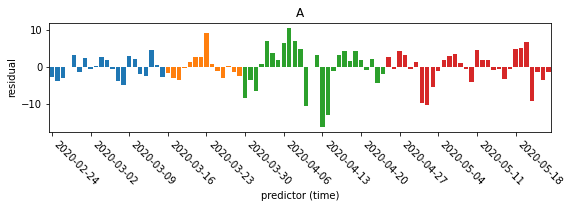

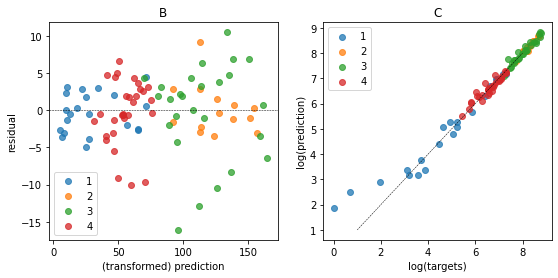

In [10]:
# log likelihood
LL_glm = np.sum(ss.poisson.logpmf(targets[0,:,0].detach(), y_hat[0,:,0].detach()))

# deviance
D_glm = 2*(LL_sat-LL_glm)

# residual degress of freedom
dof_glm = T-Dparaml*K-Dparamg

# deviance residuals (McCullagh & Nelder 1989, section 2.4)
# sanity check: D_glm = np.sum(np.square(D_glm_resid))
D_glm_resid = (torch.sign(targets[0,:,0]-y_hat[0,:,0])
                * torch.sqrt(2*(targets[0,:,0]*torch.log(targets[0,:,0]/y_hat[0,:,0])
                                 - targets[0,:,0] + y_hat[0,:,0]))).detach().numpy()

print("LL sat   = %.4f" % LL_sat)
print("LL GLM   = %.4f" % LL_glm)
print("deviance = %.4f (residual df=%d)" % (D_glm, dof_glm))
print("  (1/df) = %.4f" % (D_glm/dof_glm))

# McCullagh & Nelder (1989, section 12.6.1)
plt.figure(figsize=(9,2))
plt.title("A")
plt.xlabel("predictor (time)")
plt.ylabel("residual")
for i in range(len(segments)-1):
    plt.bar(np.linspace(0,T-1,T)[range(segments[i], segments[i+1])],
            D_glm_resid[range(segments[i], segments[i+1])])
plt.xlim(-0.5,T-0.5)
plt.xticks(range(0, T, 7), labels=[t.date() for t in time_period[::7]], rotation=-45, ha="left")
plt.show()

# McCullagh & Nelder (1989, sections 12.6.1 and 12.6.3)
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.title("B")
plt.xlabel("(transformed) prediction")
plt.ylabel("residual")
y_hat_transformed = 2*np.sqrt(y_hat[0,:,0].detach())
for i in range(len(segments)-1):
    plt.scatter(y_hat_transformed[range(segments[i], segments[i+1])],
                D_glm_resid[range(segments[i], segments[i+1])],
                label="%d"%(i+1), alpha=0.75)
plt.axhline(0, ls="--", lw=0.5, c="black")
plt.legend()
plt.subplot(122)
plt.title("C")
plt.xlabel("log(targets)")
plt.ylabel("log(prediction)")
plt.plot(np.linspace(1,8), np.linspace(1,8), lw=0.5, color="black", ls="--")
for i in range(len(segments)-1):
    plt.scatter(np.log(targets[0,:,0].detach())[range(segments[i], segments[i+1])],
                np.log(y_hat[0,:,0].detach())[range(segments[i], segments[i+1])],
                label="%d"%(i+1), alpha=0.75)
plt.legend()
plt.show()

Plots are colorized by segment identifiers. Null patterns for informal checks:
* **A:** zero mean, constant variance
* **B:** zero mean, constant variance
* **C:** straight line

We observe the null patterns. Only the plot of targets against prediction (C) indicates that the smallest three targets are overestimated, unless their form their own segment.